In [1]:
import os
import sys
import pathlib
import warnings
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import seaborn as sns

import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from llmicl.interfaces import trainers
from llmicl.rl_helpers import nn_utils

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import importlib
importlib.reload(trainers)

sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

2024-10-01 17:13:54.792569: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 17:13:54.807988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 17:13:54.827232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 17:13:54.833004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 17:13:54.847742: I tensorflow/core/platform/cpu_feature_guar

<Figure size 640x480 with 0 Axes>

## state and action names

In [2]:
state_names = {
    "HalfCheetah": [
        "rootz",
        "rooty",
        "bthigh",
        "bshin",
        "bfoot",
        "fthigh",
        "fshin",
        "ffoot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "bthigh_dot",
        "bshin_dot",
        "bfoot_dot",
        "fthigh_dot",
        "fshin_dot",
        "ffoot_dot",
        "reward",
    ],
    "Hopper": [
        "rootz",
        "rooty",
        "thigh",
        "leg",
        "foot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_dot",
        "leg_dot",
        "foot_dot",
        "reward"
    ],
    "Ant": [
        "rootz",
        "root_quat_x",
        "root_quat_y",
        "root_quat_z",
        "root_quat_w",
        "hip_1_angle",
        "ankle_1_angle",
        "hip_2_angle",
        "ankle_2_angle",
        "hip_3_angle",
        "ankle_3_angle",
        "hip_4_angle",
        "ankle_4_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "root_quat_x_dot",
        "root_quat_y_dot",
        "root_quat_z_dot",
        "hip_1_angle_dot",
        "ankle_1_angle_dot",
        "hip_2_angle_dot",
        "ankle_2_angle_dot",
        "hip_3_angle_dot",
        "ankle_3_angle_dot",
        "hip_4_angle_dot",
        "ankle_4_angle_dot",
        "reward"
    ],
    "Walker2d": [
        "rootz",
        "rooty",
        "thigh_right_angle",
        "leg_right_angle",
        "foot_right_angle",
        "thigh_left_angle",
        "leg_left_angle",
        "foot_left_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_right_angle_dot",
        "leg_right_angle_dot",
        "foot_right_angle_dot",
        "thigh_left_angle_dot",
        "leg_left_angle_dot",
        "foot_left_angle_dot",
        "reward"
    ],
    "Swimmer": [
        "rootx",
        "rootz",
        "rooty",
        "joint_1_angle",
        "joint_2_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "joint_1_angle_dot",
        "joint_2_angle_dot",
    ]
}

action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ],
    "Ant": [
        "hip_4_joint",
        "ankle_4_joint",
        "hip_1_joint",
        "ankle_1_joint",
        "hip_2_joint",
        "ankle_2_joint",
        "hip_3_joint",
        "ankle_3_joint",
    ],
    "Walker2d": [
        "thigh_left_joint",
        "leg_left_joint",
        "foot_left_joint",
        "thigh_right_joint",
        "leg_right_joint",
        "foot_right_joint",
    ],
    "Swimmer": [
        "joint_1",
        "joint_2",
    ]
}

new_notation_state = {
'HalfCheetah': [
    r"$rootz$",
    r"$rooty$",
    r"$bthigh$",
    r"$bshin$",
    r"$bfoot$",
    r"$fthigh$",
    r"$fshin$",
    r"$ffoot$",
    r"$\dot{rootx}$",
    r"$\dot{rootz}$",
    r"$\dot{rooty}$",
    r"$\dot{bthigh}$",
    r"$\dot{bshin}$",
    r"$\dot{bfoot}$",
    r"$\dot{fthigh}$",
    r"$\dot{fshin}$",
    r"$\dot{ffoot}$",
],
'Hopper': [
    r"$rootz$",
    r"$rooty$",
    r"$thigh$",
    r"$leg$",
    r"$foot$",
    r"$\dot{rootx}$",
    r"$\dot{rootz}$",
    r"$\dot{rooty}$",
    r"$\dot{thigh}$",
    r"$\dot{leg}$",
    r"$\dot{foot}$",
],
} 

## invert pca

In [3]:
def invert_pca(icl_object, reduction_object, use_scaler=True):
    groundtruth = scaling_pipeline.transform(X_values[init_index+1:init_index+context_length+1, :n_components])
    scaled_mean_error = []
    if use_scaler:
        predictions = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate([icl_object[dim].predictions[..., None] for dim in range(n_components)], axis=1)))
    else:
        predictions = reduction_object.inverse_transform(np.concatenate([icl_object[dim].predictions[..., None] for dim in range(n_components)], axis=1))
    all_mean = []
    all_mode = []
    all_lb = []
    all_ub = []
    for dim in range(n_components):
        ts_max = icl_object[dim].rescaling_max
        ts_min = icl_object[dim].rescaling_min
        # # -------------------- Useful for Plots --------------------
        mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
        mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
        sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

        all_mean.append(mean_arr[..., None])
        all_mode.append(mode_arr[..., None])
        all_lb.append(mean_arr[..., None] - sigma_arr[..., None])
        all_ub.append(mean_arr[..., None] + sigma_arr[..., None])

    if use_scaler:
        scaled_mean_error = np.abs(np.concatenate(all_mean, axis=1)[-100:] - groundtruth[-100:, :]).mean(axis=0)
    else:
        scaled_mean_error = np.abs(scaling_pipeline.transform(np.concatenate(all_mean, axis=1)[-100:]) - groundtruth[-100:, :]).mean(axis=0)
    
    if use_scaler:
        all_mean = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_mean, axis=1)))
        all_mode = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_mode, axis=1)))
        all_lb = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_lb, axis=1)))
        all_ub = scaling_pipeline.inverse_transform(reduction_object.inverse_transform(np.concatenate(all_ub, axis=1)))
    else:
        all_mean = reduction_object.inverse_transform(np.concatenate(all_mean, axis=1))
        all_mode = reduction_object.inverse_transform(np.concatenate(all_mode, axis=1))
        all_lb = reduction_object.inverse_transform(np.concatenate(all_lb, axis=1))
        all_ub = reduction_object.inverse_transform(np.concatenate(all_ub, axis=1))

    print(scaled_mean_error)

    return predictions, all_mean, all_mode, all_lb, all_ub, scaled_mean_error

## load model

In [4]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

tokenizer = AutoTokenizer.from_pretrained(
    # "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    # "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    device_map="auto",   
    torch_dtype=torch.bfloat16, 
)
print(f"finish loading model")
model.eval()

finish loading tokenizer
finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (rotary_emb): Ll

## load data

In [5]:
env_name = "HalfCheetah"
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]

# load some data to get a pool of states
data_label = "expert"
data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
X = pd.read_csv(data_path, index_col=0)
if 'obs_reward' in X.columns:
    X = X.drop(['obs_reward'], axis=1)
X_values = X.values.astype('float')

# find episodes beginnings
restart_index = n_observations+n_actions+1
reward_index = n_observations+n_actions
restarts = X_values[:, restart_index]
episode_starts = np.where(restarts)[0]
episode_starts

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000])

In [6]:
episode_starts[1:] - episode_starts[:-1]

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000])

## scaling pipeline

In [7]:
only_use_context = False

context_length = 500
rescale_factor = 7.0
up_shift = 1.5

episode = 4

init_index = episode_starts[episode]

In [8]:
obs = np.concatenate([X_values[:, :n_observations], X_values[:, reward_index:reward_index+1]],axis=1)
obs = obs[~np.isnan(obs[:,-1])]

# standard scaling
scaling_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())
scaling_pipeline.fit(obs)
obs_scaled = scaling_pipeline.transform(obs)

# PCA

In [142]:
# pca
n_components = n_observations + 1
# pca = FastICA(n_components=n_components)  # PCA
pca = PCA(n_components=n_components)
pca.fit(obs_scaled)

print(f"explained var: {pca.explained_variance_ratio_.round(3).cumsum()}")
print(f"singular_values: {pca.singular_values_}")

raw_ts = np.concatenate([
    X_values[init_index:init_index+context_length, :n_observations],
    X_values[init_index:init_index+context_length, reward_index:reward_index+1]
], axis=1) 
time_series = pca.transform(scaling_pipeline.transform(raw_ts))

explained var: [0.118 0.227 0.329 0.415 0.494 0.565 0.632 0.688 0.738 0.786 0.827 0.867
 0.904 0.941 0.964 0.98  0.993 1.001]
singular_values: [200.6093983  193.01226722 186.84551048 171.05565775 163.88312195
 155.36393321 151.5169495  138.22790899 131.08414367 127.80680552
 118.66762377 116.55621504 112.7003467  111.74299837  88.91247628
  73.79658384  67.6977118   51.20236595]


# ICL

In [143]:
trainer = trainers.RLICLTrainer(
    model=model,
    tokenizer=tokenizer,
    n_observations=n_components,  # n_observations,
    n_actions=n_actions,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

trainer.update_context(
    time_series=copy.copy(time_series), 
    mean_series=copy.copy(time_series),
    sigma_series=np.zeros_like(time_series),
    context_length=context_length,
    update_min_max=True,
)
trainer.icl(
    verbose=1,
    llama_3_tokenizer=True,
    stochastic=False
)
trainer.icl(verbose=1, stochastic=True)

prediction_horizon=1
icl_object = trainer.predict_long_horizon_llm(
    prediction_horizon=prediction_horizon, 
    stochastic=False, 
    verbose=1
)

prediction_horizon: 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.49s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


[2.31147819 2.21576253 2.47215208 0.82877356 0.76064569 0.84526148
 0.8156525  0.8290733  0.63147495 0.66034965 0.71962699 0.90561156
 0.93018208 0.8546591  0.87117491 0.87555799 0.82266188 0.81998991]


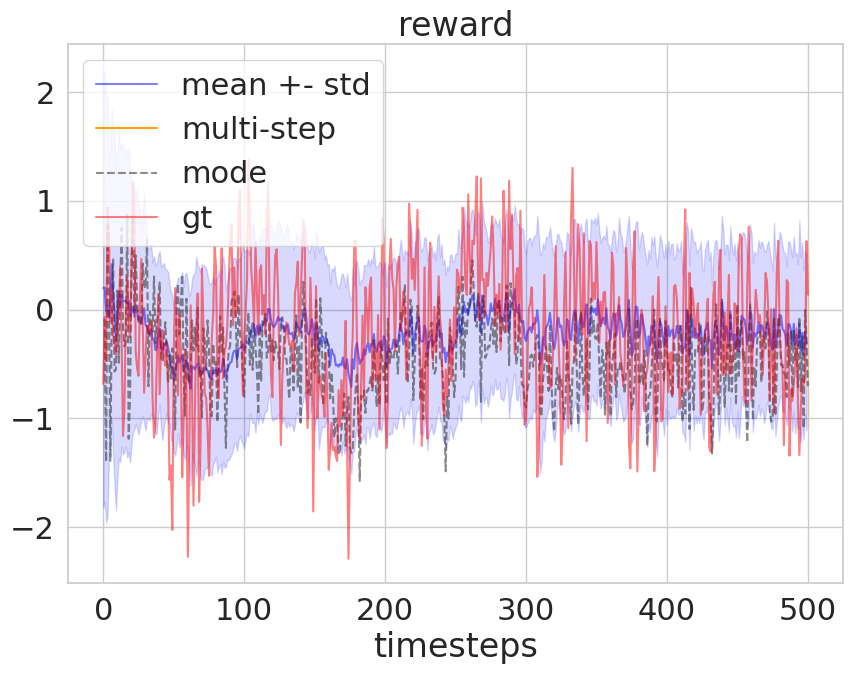

In [144]:
predictions, all_mean, all_mode, all_lb, all_ub, scaled_mean_error = invert_pca(icl_object, reduction_object=pca, use_scaler=True)

start_from = 0
dim = 0
dim_rew = -1
f, axes = plt.subplots(1, 1, figsize=(10, 7), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())

groundtruth = X_values[init_index+1:init_index+context_length+1+prediction_horizon, reward_index].flatten()

# -------------------- Trajectory visualization --------------------
x = np.arange(predictions.shape[0])
# single step
axes[dim].plot(x[start_from:-prediction_horizon], all_mean[start_from:-prediction_horizon, dim_rew], label='mean +- std', color='blue', alpha=.5)
axes[dim].fill_between(
    x=x[start_from:-prediction_horizon], 
    y1=all_lb[start_from:-prediction_horizon, dim_rew], 
    y2=all_ub[start_from:-prediction_horizon, dim_rew],
    alpha=.15,
    color='blue',
)
# multi_step
axes[dim].plot(x[-prediction_horizon:], all_mean[-prediction_horizon:, dim_rew], label='multi-step', color='orange')
axes[dim].fill_between(
    x=x[-prediction_horizon:], 
    y1=all_lb[-prediction_horizon:, dim_rew], 
    y2=all_ub[-prediction_horizon:, dim_rew],
    alpha=.3,
    color='orange',
)

axes[dim].plot(x[start_from:], all_mode[start_from:, dim_rew], 'k--', label='mode', alpha=.5)

axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
axes[dim].set_title(f"reward")
axes[dim].set_xlabel("timesteps")
    # axes[dim].set_ylabel("feature")
axes[dim].legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"multi_step_halfcheetah_expert.png")
plt.show()

# full loop with PCA

In [ ]:
df_list = []
# env_name = "Walker2d"
for env_name in ['HalfCheetah']:
    env = gym.make(env_name)
    n_actions = env.action_space.shape[0]
    n_observations = env.observation_space.shape[0]
    
    # load some data to get a pool of states
    # data_label = "expert"
    for data_label in ['expert']:
        data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
        X = pd.read_csv(data_path, index_col=0)
        if 'obs_reward' in X.columns:
            X = X.drop(['obs_reward'], axis=1)
        X_values = X.values.astype('float')
        
        # find episodes beginnings
        restart_index = n_observations+n_actions+1
        reward_index = n_observations+n_actions
        restarts = X_values[:, restart_index]
        episode_starts = np.where(restarts)[0]

        # pca_with_actions = True
        # episode = 10
        # init_index = episode_starts[episode]
        n_episodes = 2
        for init_index in np.random.choice(episode_starts, (n_episodes,)):
            for pca_with_actions in [True, False]:
                if pca_with_actions:
                    obs_act = X_values[:, : n_observations + n_actions + 1]
                    obs_act = obs_act[~np.isnan(obs_act[:, -1])]
                    scaling_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())
                    scaling_pipeline.fit(obs_act)
                    obs_act_scaled = scaling_pipeline.transform(obs_act)
                else:
                    obs = np.concatenate([X_values[:, :n_observations], X_values[:, reward_index:reward_index+1]],axis=1)
                    obs = obs[~np.isnan(obs[:,-1])]
                    # standard scaling
                    scaling_pipeline = make_pipeline(MinMaxScaler(), StandardScaler())
                    scaling_pipeline.fit(obs)
                    obs_scaled = scaling_pipeline.transform(obs)
                
                # pca
                n_components = n_observations + 1  # +1 for reward
                n_components += n_actions if pca_with_actions else 0
                # n_components = int(n_components/2)
                # pca = FastICA(n_components=n_components)  # PCA
                pca = PCA(n_components=n_components)
                if pca_with_actions:
                    pca.fit(obs_act_scaled)
                else:
                    pca.fit(obs_scaled)
            
                if pca_with_actions:
                    raw_ts = X_values[init_index:init_index+context_length, :n_observations+n_actions+1]
                else:
                    raw_ts = np.concatenate([
                        X_values[init_index:init_index+context_length, :n_observations],
                        X_values[init_index:init_index+context_length, reward_index:reward_index+1]
                    ], axis=1) 
                time_series = pca.transform(
                    scaling_pipeline.transform(
                        raw_ts
                    )
                )
                
                prediction_horizon = 499  # up tp 499 (not 500)
                
                # recreate the trainer
                trainer = trainers.RLICLTrainer(
                    model=model,
                    tokenizer=tokenizer,
                    n_observations=n_components,
                    n_actions=n_actions,
                    rescale_factor=rescale_factor,
                    up_shift=up_shift,
                )
                
                trainer.update_context(
                    time_series=copy.copy(time_series), 
                    mean_series=copy.copy(time_series),
                    sigma_series=np.zeros_like(time_series),
                    context_length=context_length,
                    update_min_max=True,
                )
                trainer.icl(verbose=1, stochastic=True)
                
                icl_object = trainer.predict_long_horizon_llm(
                    prediction_horizon=prediction_horizon, 
                    stochastic=True, 
                    verbose=1
                )
                
                mean_arr = [
                    (
                        ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor)
                        * (icl_object[dim].rescaling_max - icl_object[dim].rescaling_min)
                        + icl_object[dim].rescaling_min
                    )[..., None]
                    for dim in range(n_components)
                ]
                mean_arr = scaling_pipeline.inverse_transform(pca.inverse_transform(np.concatenate(mean_arr, axis=1)))
                
                # mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
                # mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
                # sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)
                # pred_arr = icl_object[dim].predictions.flatten()
    
                groundtruth = X_values[init_index:init_index+999, reward_index].flatten()
                V_true = groundtruth.sum()
                v_error = []
                V = 0.0
                V_hat = 0.0
                for h in range(context_length, context_length+prediction_horizon):
                    V += groundtruth[h]
                    V_hat += mean_arr[h-1, -1]
                    v_error.append(100*float(np.abs(V-V_hat)/V_true))
    
                # print(f"mean arr: {mean_arr[context_length-1:-1, -1].shape}")
                # print(f"groundtruth: {groundtruth[context_length:context_length+prediction_horizon].shape}")
                # print(f"v_error: {len(v_error)}")
    
                df = pd.DataFrame({
                    'mean': mean_arr[context_length-1:-1, -1],
                    # 'sigma': sigma_arr[context_length:-1],
                    # 'mode': mode_arr[context_length:-1],
                    # 'pred': pred_arr[context_length:-1],
                    'gt': groundtruth[context_length:context_length+prediction_horizon],
                    'value_error': v_error,
                })
                df['env_name'] = env_name
                df['data_label'] = data_label
                df['init_index'] = init_index
                df['algorithm'] = r'$(s,a,r)$-pca' if pca_with_actions else r'$(s,r)$-pca' 
                df_list.append(df)
                df_all = pd.concat(df_list, axis=0)
                df_all.to_csv('/mnt/vdb/abenechehab/icl_paper/figures/mbpe_pca_extended_last_minute.csv')

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(
prediction_horizon: 100%|████████████████████████████████████████████████████████████████████████████| 499/499 [3:08:37<00:00, 22.68s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr
prediction_horizon:  85%|████████████████████

# reward only

In [219]:
df_list = []
# env_name = "Walker2d"
for env_name in ['HalfCheetah', 'Walker2d', 'Hopper', 'Ant']:
    env = gym.make(env_name)
    n_actions = env.action_space.shape[0]
    n_observations = env.observation_space.shape[0]
    
    # load some data to get a pool of states
    # data_label = "expert"
    for data_label in ['expert']:
        data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
        X = pd.read_csv(data_path, index_col=0)
        if 'obs_reward' in X.columns:
            X = X.drop(['obs_reward'], axis=1)
        X_values = X.values.astype('float')
        
        # find episodes beginnings
        restart_index = n_observations+n_actions+1
        reward_index = n_observations+n_actions
        restarts = X_values[:, restart_index]
        episode_starts = np.where(restarts)[0]
        
        # episode = 10
        # init_index = episode_starts[episode]
        for init_index in np.random.choice(episode_starts, (3,)):
            time_series = X_values[init_index:init_index+context_length, reward_index:reward_index+1]
            
            prediction_horizon = 500
            
            # recreate the trainer
            trainer = trainers.RLICLTrainer(
                model=model,
                tokenizer=tokenizer,
                n_observations=1,
                n_actions=n_actions,
                rescale_factor=rescale_factor,
                up_shift=up_shift,
            )
            
            trainer.update_context(
                time_series=copy.copy(time_series), 
                mean_series=copy.copy(time_series),
                sigma_series=np.zeros_like(time_series),
                context_length=context_length,
                update_min_max=True,
            )
            trainer.icl(verbose=1, stochastic=True)
            
            icl_object = trainer.predict_long_horizon_llm(
                prediction_horizon=prediction_horizon, 
                stochastic=True, 
                verbose=1
            )
            dim=0
            ts_max = icl_object[dim].rescaling_max
            ts_min = icl_object[dim].rescaling_min
            
            mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
            mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
            sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)
            pred_arr = icl_object[dim].predictions.flatten()

            groundtruth = X_values[init_index:init_index+999, reward_index].flatten()
            V_true = groundtruth.sum()
            v_error = []
            V = 0.0
            V_hat = 0.0
            for h in range(context_length, context_length+prediction_horizon-1):
                V += groundtruth[h]
                V_hat += mean_arr[h-1]
                v_error.append(100*float(np.abs(V-V_hat)/V_true))

            # print(f"mean arr: {mean_arr[context_length:-1].shape}")
            # print(f"groundtruth: {groundtruth[context_length:context_length+prediction_horizon].shape}")
            # print(f"v_error: {len(v_error)}")

            df = pd.DataFrame({
                'mean': mean_arr[context_length:-1],
                'sigma': sigma_arr[context_length:-1],
                'mode': mode_arr[context_length:-1],
                'pred': pred_arr[context_length:-1],
                'gt': groundtruth[context_length:context_length+prediction_horizon],
                'value_error': v_error,
            })
            df['env_name'] = env_name
            df['data_label'] = data_label
            df['init_index'] = init_index
            df_list.append(df)
        df_all = pd.concat(df_list, axis=0)
        df_all.to_csv('/mnt/vdb/abenechehab/icl_paper/figures/mbpe.csv')

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(
prediction_horizon: 100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [29:34<00:00,  3.55s/it]
/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr
prediction_horizon: 100%|████████████████████

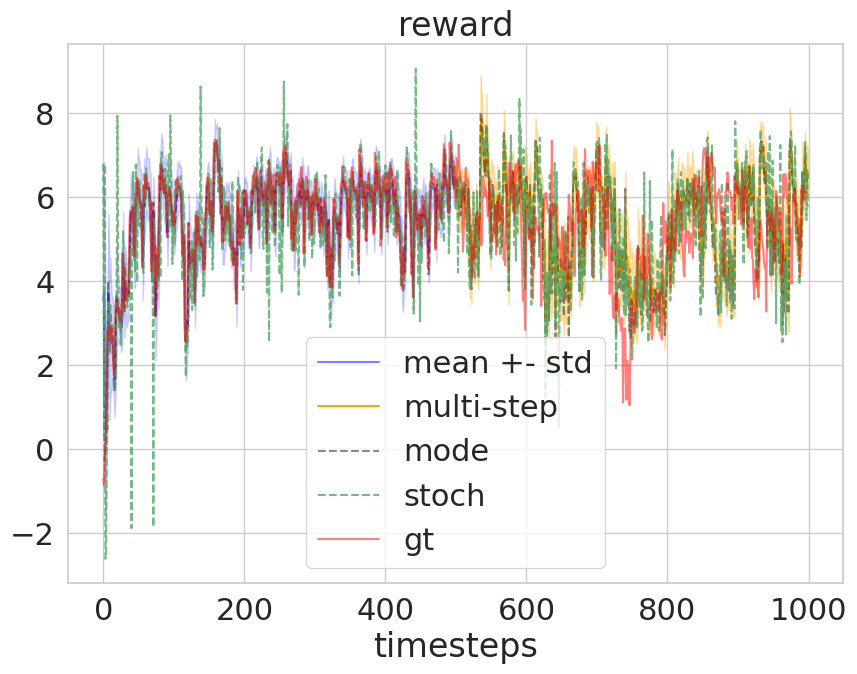

In [220]:
start_from = 0
dim = 0
f, axes = plt.subplots(1, 1, figsize=(10, 7), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())

groundtruth = X_values[init_index+1:init_index+context_length+1+prediction_horizon, reward_index].flatten()
size_all = len(groundtruth)

ts_max = icl_object[dim].rescaling_max
ts_min = icl_object[dim].rescaling_min

# -------------------- Useful for Plots --------------------
mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

# -------------------- Trajectory visualization --------------------
x = np.arange(mean_arr.shape[0])
# single step
axes[dim].plot(x[start_from:-prediction_horizon], mean_arr[start_from:-prediction_horizon], label='mean +- std', color='blue', alpha=.5)
axes[dim].fill_between(
    x=x[start_from:-prediction_horizon], 
    y1=mean_arr[start_from:-prediction_horizon]-sigma_arr[start_from:-prediction_horizon], 
    y2=mean_arr[start_from:-prediction_horizon]+sigma_arr[start_from:-prediction_horizon],
    alpha=.15,
    color='blue',
)
# multi_step
axes[dim].plot(x[-prediction_horizon:], mean_arr[-prediction_horizon:], label='multi-step', color='orange')
axes[dim].fill_between(
    x=x[-prediction_horizon:], 
    y1=mean_arr[-prediction_horizon:]-sigma_arr[-prediction_horizon:], 
    y2=mean_arr[-prediction_horizon:]+sigma_arr[-prediction_horizon:],
    alpha=.3,
    color='orange',
)

axes[dim].plot(x[start_from:], mode_arr[start_from:], 'k--', label='mode', alpha=.5)
axes[dim].plot(x[start_from:], icl_object[dim].predictions.flatten(), 'g--', label='stoch', alpha=.8)

axes[dim].plot(x[start_from:], groundtruth[start_from:], label='gt', color='red', alpha=.5)
axes[dim].set_title(f"reward")
axes[dim].set_xlabel("timesteps")
    # axes[dim].set_ylabel("feature")
axes[dim].legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"multi_step_halfcheetah_expert.png")
plt.show()

# plots: reward prediction + value error

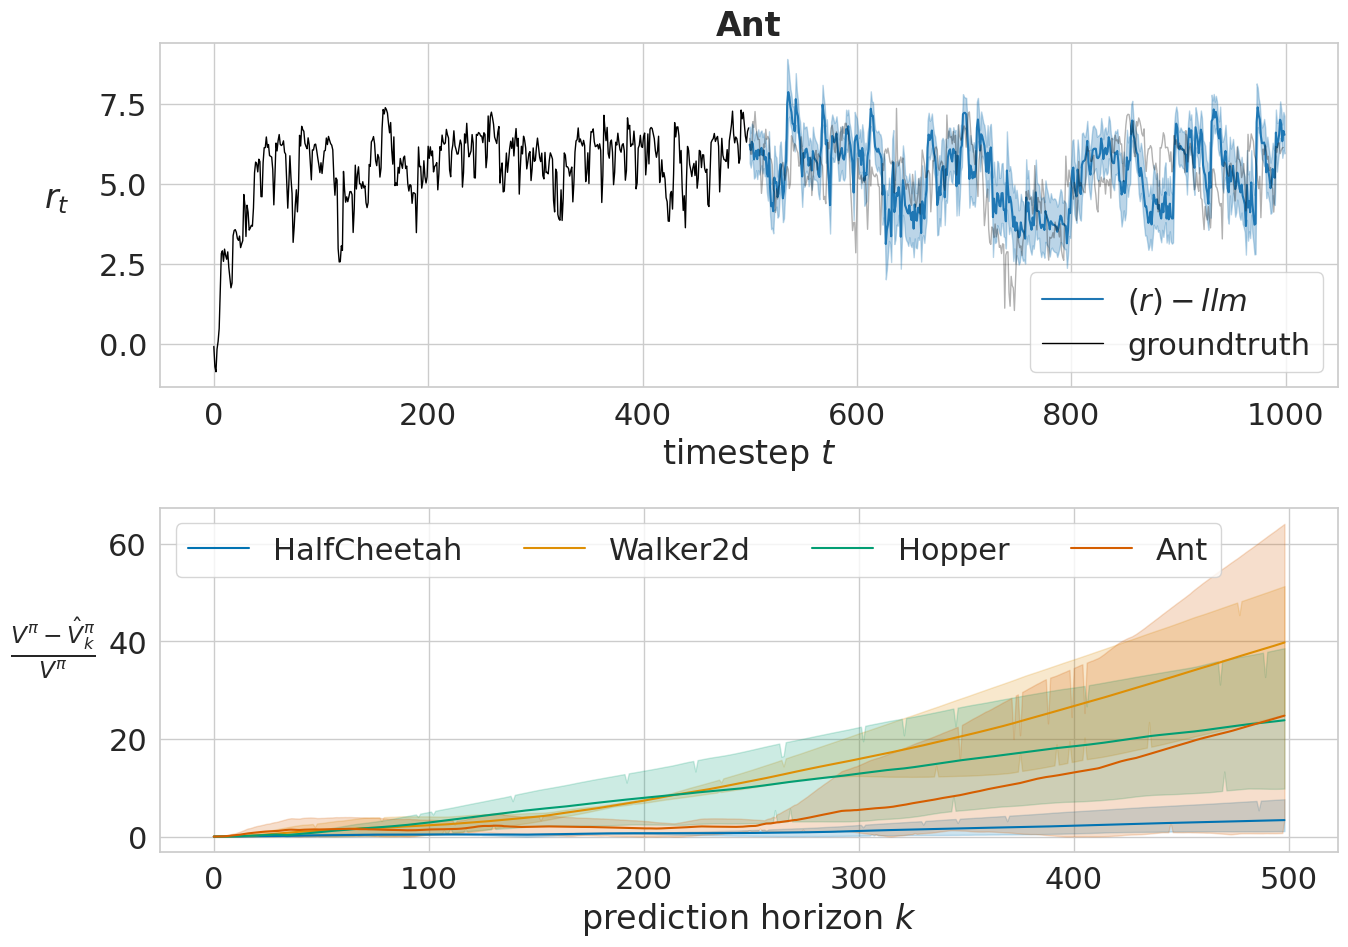

In [226]:
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(plt.cm.tab10.colors[:10])

start_from = 0
f, axes = plt.subplots(2, 1, figsize=(14, 10))
axes = list(np.array(axes).flatten())
dim=0
groundtruth = X_values[init_index:init_index+1000, reward_index].flatten()
size_all = len(groundtruth)

ts_max = icl_object[dim].rescaling_max
ts_min = icl_object[dim].rescaling_min

# -------------------- Useful for Plots --------------------
mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

# -------------------- Trajectory visualization --------------------
x = np.arange(1000)
# axes[dim].plot(
#     x[context_length:context_length+prediction_horizon], 
#     mode_arr[-prediction_horizon:], 
#     'k--', label='mode', alpha=.9
# )
# multi_step
axes[dim].plot(
    x[context_length:context_length+prediction_horizon], 
    mean_arr[-prediction_horizon:], 
    label=r'$(r)-llm$', 
    color=cmap(0)
)
axes[dim].fill_between(
    x=x[context_length:context_length+prediction_horizon], 
    y1=mean_arr[-prediction_horizon:]-sigma_arr[-prediction_horizon:], 
    y2=mean_arr[-prediction_horizon:]+sigma_arr[-prediction_horizon:],
    alpha=.3,
    color=cmap(0),
)

axes[dim].plot(
    x[start_from:context_length], 
    groundtruth[start_from:context_length], 
    label='groundtruth', c='black', linewidth=1)
axes[dim].plot(
    x[context_length: context_length+prediction_horizon], 
    groundtruth[context_length: context_length+prediction_horizon],
    alpha=.3, c='black', linewidth=1
)
axes[dim].plot(
    x[context_length+prediction_horizon:], 
    groundtruth[context_length+prediction_horizon:], 
    c='black',
    linewidth=1
)
axes[dim].set_ylabel(r"$r_t$", rotation=0, labelpad=30)
axes[dim].set_xlabel(r"timestep $t$")
axes[dim].set_title('Ant', fontweight="bold")
# axes[dim].set_ylabel("feature")
axes[dim].legend()
# f.suptitle(f'Halfcheetah - expert policy', y=-1.1)
# plt.savefig(f"multi_step_halfcheetah_expert.png")
"""
groundtruth = X_values[init_index:init_index+999, reward_index].flatten()
V_true = groundtruth.sum()
print(f"V_true: {V_true}")
v_error = []
V = 0.0
V_hat = 0.0
for h in range(context_length, context_length+prediction_horizon-1):
    V += groundtruth[h]
    V_hat += mean_arr[h-1]
    v_error.append(100*float(np.abs(V-V_hat)/V_true))
axes[1].plot(np.arange(len(v_error)), np.array(v_error), c=cmap(6))
axes[1].set_ylabel(r"$\frac{V^\pi-\hat{V}_k^\pi}{V^\pi}$", rotation=0, labelpad=30)
axes[1].set_xlabel(r"prediction horizon $k$")
"""
df_all['abs_value_error'] = np.abs(df_all['value_error'])
sns.lineplot(data=df_all.reset_index(), x='index', y='abs_value_error', hue='env_name', ax=axes[1])
axes[1].set_ylabel(r"$\frac{V^\pi-\hat{V}_k^\pi}{V^\pi}$", rotation=0, labelpad=40)
axes[1].set_xlabel(r"prediction horizon $k$")
axes[1].legend(ncol=6)


# plt.ticklabel_format(style='scientific', scilimits=(0,0))
plt.tight_layout()
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/ope_allenvs_data{data_label}_nep{3}.pdf', bbox_inches='tight')
plt.show()

# Baselines

In [305]:
training_data_size = 2000
df_list = []
# env_name = "Walker2d"
for env_name in ['HalfCheetah', 'Walker2d', 'Hopper', 'Ant']:
    env = gym.make(env_name)
    n_actions = env.action_space.shape[0]
    n_observations = env.observation_space.shape[0]
    
    # load some data to get a pool of states
    # data_label = "expert"
    for data_label in ['expert']:
        data_path = f"/home/abenechehab/datasets/{env_name}/{data_label}/X_test.csv"
        X = pd.read_csv(data_path, index_col=0)
        if 'obs_reward' in X.columns:
            X = X.drop(['obs_reward'], axis=1)
        X_values = X.values.astype('float')
        
        # find episodes beginnings
        restart_index = n_observations+n_actions+1
        reward_index = n_observations+n_actions
        restarts = X_values[:, restart_index]
        episode_starts = np.where(restarts)[0]

        # ------------ train baselines ------------
        data_path = f"/home/abenechehab/datasets/{env_name}/expert/X_train.csv"
        X_baselines = pd.read_csv(data_path, index_col=0)
        if 'obs_reward' in X.columns:
            X_baselines = X_baselines.drop(['obs_reward'], axis=1)
        X_baselines = X_baselines.values.astype('float')
        X_train_actions = copy.copy(X_baselines[:,:n_observations+n_actions])[:-1]
        X_train = copy.copy(np.concatenate([X_baselines[:,:n_observations]], axis=1)[:-1])
        y_train = copy.copy(np.concatenate([X_baselines[1:,:n_observations], X_baselines[:-1,n_observations+n_actions:n_observations+n_actions+1]], axis=1))
        
        nan_indices = np.unique(np.concatenate([np.argwhere(np.isnan(X_train_actions))[:,0], np.argwhere(np.isnan(y_train))[:,0]]))
        mask = np.ones(X_train_actions.shape[0], bool)
        mask[nan_indices] = False
        
        X_train = X_train[mask][:training_data_size]
        X_train_actions = X_train_actions[mask][:training_data_size]
        y_train = y_train[mask][:training_data_size]
        
        # linreg model
        linreg_model = LinearRegression(fit_intercept=True)
        linreg_model.fit(X_train, y_train)
        # linreg model action
        linreg_model_actions = LinearRegression(fit_intercept=True)
        linreg_model_actions.fit(X_train_actions, y_train)
        # mlp
        mlp = nn_utils.NeuralNet(input_size=n_observations, output_size=n_observations+1)
        _, _, mlp = nn_utils.train_mlp(model=mlp, X_train=X_train, y_train=y_train, verbose=1)
        mlp.eval()
        # mlp + actions
        mlp_actions = nn_utils.NeuralNet(input_size=n_observations+n_actions, output_size=n_observations+1)
        _, _, mlp_actions = nn_utils.train_mlp(model=mlp_actions, X_train=X_train_actions, y_train=y_train, verbose=1)
        mlp_actions.eval()

        # episode = 10
        # init_index = episode_starts[episode]
        for init_index in np.random.choice(episode_starts, (3,)):
            prediction_horizon = 500
            # time_series = X_values[init_index:init_index+context_length+prediction_horizon, :n_observations+n_actions+1]
            # nan_indices = np.unique(np.argwhere(np.isnan(X_train_actions))[:,0])
            # mask = np.ones(X_train_actions.shape[0], bool)
            # mask[nan_indices] = False
            
            # X_train = X_train[mask][:training_data_size]
            
            # ------------ multi-step prediction with baselines -----------
            # linear actions
            linreg_input_actions = X_values[init_index:init_index+context_length+prediction_horizon-1,:n_observations+n_actions]
            linreg_pred_actions = linreg_model_actions.predict(linreg_input_actions)
            
            # linear
            linreg_input = np.concatenate([
                X_values[init_index:init_index+context_length+prediction_horizon-1,:n_observations], 
            ], axis=1)
            linreg_pred = linreg_model.predict(linreg_input)
            
            #mlp
            mlp_pred = mlp(torch.from_numpy(linreg_input).type(torch.FloatTensor)).cpu().detach().numpy()
            
            #mlp + actions
            mlp_actions_pred = mlp_actions(torch.from_numpy(linreg_input_actions).type(torch.FloatTensor)).cpu().detach().numpy()
            
            # multi-step prediction
            for h in range(prediction_horizon-1):
                # linear + actions
                new_input_actions = np.concatenate(
                    [
                        linreg_pred_actions[context_length+h-1,:-1].reshape((1, -1)), 
                        X_values[init_index+context_length+h,n_observations:n_observations+n_actions].reshape((1, -1))
                    ], 
                    axis=1
                )
                new_pred_actions = linreg_model_actions.predict(new_input_actions)
                linreg_pred_actions[context_length+h] = copy.copy(new_pred_actions)
                # linear
                new_pred = linreg_model.predict(linreg_pred[context_length+h-1,:-1].reshape((1, -1)))
                linreg_pred[context_length+h] = copy.copy(new_pred)
                # mlp
                new_pred = mlp(torch.from_numpy(mlp_pred[context_length+h-1,:-1].reshape((1, -1))).type(torch.FloatTensor)).cpu().detach().numpy()
                mlp_pred[context_length+h] = copy.copy(new_pred)
                # mlp actions
                new_input_actions = np.concatenate(
                    [
                        mlp_actions_pred[context_length+h-1,:-1].reshape((1, -1)), 
                        X_values[init_index+context_length+h,n_observations:n_observations+n_actions].reshape((1, -1))
                    ], 
                    axis=1
                )
                new_pred_actions = mlp_actions(torch.from_numpy(new_input_actions).type(torch.FloatTensor)).cpu().detach().numpy()
                mlp_actions_pred[context_length+h] = copy.copy(new_pred_actions)

            for bs in ['linreg_pred_actions', 'linreg_pred', 'mlp_pred', 'mlp_actions_pred']:
                groundtruth = X_values[init_index:init_index+999, reward_index].flatten()
                V_true = float(groundtruth.sum())
                v_error = []
                V = 0.0
                V_hat = 0.0
                for h in range(context_length, context_length+prediction_horizon-1):
                    V += groundtruth[h]
                    V_hat += eval(bs)[h, -1]  # -1 because reward is the last dim
                    v_error.append(100*float(np.abs((V-V_hat)/V_true)))
    
                # print(f"mean arr: {eval(bs)[context_length:].shape}")
                # print(f"groundtruth: {groundtruth[context_length:context_length+prediction_horizon].shape}")
                # print(f"v_error: {len(v_error)}")
    
                df = pd.DataFrame({
                    'pred': eval(bs)[context_length:, -1],
                    'gt': groundtruth[context_length:context_length+prediction_horizon],
                    'value_error': v_error,
                })
                df['env_name'] = env_name
                df['data_label'] = data_label
                df['init_index'] = init_index
                df['algorithm'] = bs
                df_list.append(df)
        df_baselines = pd.concat(df_list, axis=0)
        df_baselines.to_csv('/mnt/vdb/abenechehab/icl_paper/figures/mbpe_baselines.csv')

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(
training epochs: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.08it/s]
/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `Walker2d-v4` instead of the unversioned environment `Walker2d`.
  logger.warn(
training epochs: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.15it/s]
/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `Hopper-v4` instead of the unversioned environment `Hopper`.
  logger

In [ ]:
start_from = 0
f, axes = plt.subplots(2, 1, figsize=(20, 10))
axes = list(np.array(axes).flatten())
dim=0
groundtruth = X_values[init_index:init_index+1000, reward_index].flatten()
size_all = len(groundtruth)

# ts_max = icl_object[dim].rescaling_max
# ts_min = icl_object[dim].rescaling_min

# # -------------------- Useful for Plots --------------------
# mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
# mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
# sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

# # -------------------- Trajectory visualization --------------------
x = np.arange(1000)
# # axes[dim].plot(
# #     x[context_length:context_length+prediction_horizon], 
# #     mode_arr[-prediction_horizon:], 
# #     'k--', label='mode', alpha=.9
# # )
# # multi_step
# axes[dim].plot(
#     x[context_length:context_length+prediction_horizon], 
#     mean_arr[-prediction_horizon:], 
#     label=r'$(r)-llm$', 
#     color=cmap(0)
# )
# axes[dim].fill_between(
#     x=x[context_length:context_length+prediction_horizon], 
#     y1=mean_arr[-prediction_horizon:]-sigma_arr[-prediction_horizon:], 
#     y2=mean_arr[-prediction_horizon:]+sigma_arr[-prediction_horizon:],
#     alpha=.3,
#     color=cmap(0),
# )

axes[dim].plot(
    x[start_from:], 
    groundtruth[start_from:], 
    label='groundtruth', c='black', linewidth=2)
# axes[dim].plot(
#     x[context_length: context_length+prediction_horizon], 
#     groundtruth[context_length: context_length+prediction_horizon],
#     alpha=.3, c='black', linewidth=1
# )
# axes[dim].plot(
#     x[context_length+prediction_horizon:], 
#     groundtruth[context_length+prediction_horizon:], 
#     c='black',
#     linewidth=1
# )

axes[dim].plot(
    x[start_from:-1], 
    linreg_pred[start_from:, -1], 
    label=r'$linreg$', 
    color=cmap(0)
)
axes[dim].plot(
    x[start_from:-1], 
    linreg_pred_actions[start_from:, -1], 
    label=r'$linreg_actions$', 
    color=cmap(1)
)
axes[dim].plot(
    x[start_from:-1], 
    mlp_pred[start_from:, -1], 
    label=r'$mlp$', 
    color=cmap(2)
)
axes[dim].plot(
    x[start_from:-1], 
    mlp_actions_pred[start_from:, -1], 
    label=r'$mlp_actions$', 
    color=cmap(3)
)

# axes[dim].set_ylabel(r"$r_t$", rotation=0, labelpad=30)
# axes[dim].set_xlabel(r"timestep $t$")
axes[dim].set_title(f'{env_name}, {data_label}, ep starts at {init_index}, trained on expert', fontweight="bold")
# axes[dim].set_ylabel("feature")
axes[dim].legend(ncol=6)

axes[dim].set_ylim([-5,10])